Can I predict the probabillity of a successful squat attempt for a competitor in a powerlifting meet? Openpowerlifting have a comprehensive dataset containg over 1.3 million metrics from IPF (International Powerlifting Federation) Meets. I will be using this dataset and the PyTorch machine learning library, to create a squat attempt success estimator in Python.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import os
import pickle

torch.manual_seed(71)
np.random.seed(71)

I want to create a Feed-Forward neural network. I had some trouble with numerical stabillity and exploding gradients in prior versions when working with sigmoid, so I added bach normalization, dropout layers and xavier initialization

In [2]:
class FFSquatNet(nn.Module):
    def __init__(self, input_size=8):
        super(FFSquatNet, self).__init__()

        self.layer1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.layer2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.layer3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
       
        """
        I need sepearate heads for the 2nd and 3rd attemps, since they
        are sequential and not independent 
        """
        self.second_attempt = nn.Linear(64, 1)
        self.third_attempt = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

         # Xavier initialization, to prevent exploding/vanishing gradients
        for layer in [self.layer1, self.layer2, self.layer3,
                     self.second_attempt, self.third_attempt]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        # These layers are shared 
        x = self.relu(self.bn1(self.layer1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.dropout(x)
        # shared features
        shared_features = self.relu(self.bn3(self.layer3(x)))
        shared_features = self.dropout(shared_features)

        # Seperate again for predictions 
        second_logit = self.second_attempt(shared_features)
        third_logit = self.third_attempt(shared_features)

        # Apply sigmoid to get the respective probabilities
        second_prob = torch.sigmoid(second_logit)
        third_prob = torch.sigmoid(third_logit)
        
        return torch.cat([second_prob, third_prob], dim=1)


I need to make a custom loss function that considers the sequential nature of the attempts. There exists an sequential constraint, since the success rate of the 3rd attempt would generally be lower than the success rate of the 2nd attempt. I can therefore add a penalty if the 3rd probabillity is greater than the 2nd attempt probability.

In [3]:
def sequential_loss(predictions, targets, alpha=0.1):  
    bce_loss = nn.BCELoss()
    loss = bce_loss(predictions, targets)
    sequential_penalty = torch.relu(predictions[:, 1] - predictions[:, 0]).mean()
    return loss + alpha * sequential_penalty

In [4]:
def load_data(filepath):
    df = pd.read_csv(filepath, low_memory=False)
    print(f"Original Shape of Dataset: {df.shape}")
    return df

In [5]:
def clean_data(df):
    # A lifter must have a valid, successful first attempt to be considered
    cols = ['Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'BodyweightKg', 'Age', 'Sex']
    df_clean = df.copy().dropna(subset=['BodyweightKg', 'Age', 'Sex'])
    df_clean = df_clean[df_clean['Squat1Kg'] > 0]  # Valid first attempt

    # Remove all the unattempted lifts
    df_clean['Squat2Kg'] = df_clean['Squat2Kg'].fillna(0)  
    df_clean['Squat3Kg'] = df_clean['Squat3Kg'].fillna(0)  
    # Filter out outliers (very young/old or light/heavy lifters)
    df_clean = df_clean[(df_clean['Age'] >= 15) & (df_clean['Age'] <= 65)]
    df_clean = df_clean[(df_clean['BodyweightKg'] >= 40) & (df_clean['BodyweightKg'] <= 210)]
    df_clean['Sex'] = df_clean['Sex'].map({'M': 1, 'F': 0}).fillna(df_clean['Sex'].mode()[0])
    # Ensure 'Sex' column is numeric after imputation
    df_clean['Sex'] = pd.to_numeric(df_clean['Sex'], errors='coerce').fillna(df_clean['Sex'].mode()[0])
    df_clean['Dots'] = pd.to_numeric(df_clean['Dots'], errors='coerce')

    print(f"Shape of Cleaned Dataset: {df_clean.shape}")
    return df_clean

In [6]:
def features_and_targets(df):
    
    features = pd.DataFrame()
    features['Age'] = df['Age']
    features['BodyweightKg'] = df['BodyweightKg']
    features['Sex'] = df['Sex']
    features['First_Attempt'] = df['Squat1Kg']
    features['Wilks'] = df['Dots'] if 'Wilks' in df.columns else df.get('Dots', 0)
    features['Relative_Strength'] = df['Squat1Kg'] / df['BodyweightKg']
    """"
    I have to add estimated 2nd and 3rd attept weights based on 
    common lifting strategies. The weight jump between the 2nd and 3rd 
    attempt is usually much lower than between the 1st and 2nd attempt
    """
    features['Estimated_2nd_Attempt'] = df['Squat1Kg'] * 1.05
    features['Estimated_3rd_Attempt'] = df['Squat1Kg'] * 1.08

    targets = pd.DataFrame()
    # Positive values are successful attempts and negative value are failed attempts
    targets['Success_2nd_Attempt'] = (df['Squat2Kg'] > 0).astype(float)
    targets['Success_3rd_Attempt'] = (df['Squat3Kg'] > 0).astype(float)

    # Remove rows were 2nd or 3rd lifts are not attempted
    mask = ~(features.isna().any(axis=1) | np.isinf(features).any(axis=1) |
             targets.isna().any(axis=1) | np.isinf(targets).any(axis=1))
  
    features = features[mask]
    targets = targets[mask]

    print(f"Shape of Features: {features.shape}")
    print(f"Shape of Targets: {targets.shape}")
    print(f"\nSquat attempt success rates:")
    print(f"2nd attempt: {targets['Success_2nd_Attempt'].mean()*100:.1f}%")
    print(f"3rd attempt: {targets['Success_3rd_Attempt'].mean()*100:.1f}%")
 
    return features.values, targets.values


I need to create PyTorch DataLoaders for both taining and testing. Since the dataset is rather large, I will use a 80% training and 20% testing split.
I need to scale and convert all the data to PyTorch tensors.

In [7]:
def data_loaders(X, y, test_size=0.2, batch_size=128, random_state=71):
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

   scaler = StandardScaler()
   X_train_scaled = scaler.fit_transform(X_train)
   X_test_scaled = scaler.transform(X_test)

   y_train_success = y_train[:, :2].astype(np.float32)
   y_test_success = y_test[:, :2].astype(np.float32)

   # I must convert the data to tensors for training
   X_train_tensor = torch.FloatTensor(X_train_scaled)
   y_train_tensor = torch.FloatTensor(y_train_success)
   X_test_tensor = torch.FloatTensor(X_test_scaled)
   y_test_tensor = torch.FloatTensor(y_test_success)

   train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
   test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

   train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
   test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

   return train_loader, test_loader, scaler, X_test_tensor, y_test, y_test_success

 I now need to train the model. I am using the T4 GPU's of Kaggle, which is cuda compatible. I added the weight decay and clipping due to bugs and numerical instabillity in prior testing.

In [8]:
def train_model(train_loader, test_loader, input_size=8, num_epochs=120, learning_rate=1.5e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FFSquatNet(input_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 30
  
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        num_train_batches = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            predictions = model(batch_X)
            loss = sequential_loss(predictions, batch_y)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            
        # Validation phase
        model.eval()
        val_loss = 0.0
        num_val_batches = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                predictions = model(batch_X)
                loss = sequential_loss(predictions, batch_y)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
            
        # I want to see the progress for every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return model, train_losses, val_losses

In [9]:
def evaluate_model(model, X_test, y_test_scaled, y_test):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        predictions = model(X_test).cpu().numpy() # Predictions are raw logits

        y_test_np = y_test # Since y_test is already a numpy array

        """
        I need to convert the probabilities to binary predictions, greater than
        0.5 will be considered a success
        """
        # Apply sigmoid to get probabilities from raw logits
        pred_probs = 1 / (1 + np.exp(-predictions))
        pred_success = (pred_probs > 0.5).astype(int)
        actual_success = y_test_np[:, :2] # Only take the success columns from y_test

        for i, attempt in enumerate(['2nd', '3rd']):
            accuracy = np.mean(pred_success[:, i] == actual_success[:, i])
            # Handle potential NaN in pred_probs before calculating mean
            avg_prob = np.nanmean(pred_probs[:, i]) if np.any(np.isnan(pred_probs[:, i])) else np.mean(pred_probs[:, i])
            actual_success_rate = np.mean(actual_success[:, i])
            print(f"{attempt} Success Prediction:")
            print(f"Accuracy: {accuracy*100:.2f}%")
            print(f"Average Predicted Probability: {avg_prob*100:.2f}%")
            print(f"Actual Success Rate: {actual_success_rate*100:.2f}%")

       
    return predictions

I want my model to predict the probabillity of success of a lifters planned squat attempts.

In [10]:
def predict_with_attempt_weights(model, scaler, lifter_data, second_attempt, third_attempt):
    
    """
    I want to predict the success of the actual attempts planned by the user
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    # Update the lifter data with actual attempt weights
    lifter_data['Estimated_2nd_Attempt'] = second_attempt
    lifter_data['Estimated_3rd_Attempt'] = third_attempt
    
    # Convert to array and scale
    lifter_array = np.array(list(lifter_data.values())).reshape(1, -1)
    lifter_scaled = scaler.transform(lifter_array)
    lifter_tensor = torch.FloatTensor(lifter_scaled).to(device)
    
    with torch.no_grad():
        predictions = model(lifter_tensor).cpu().numpy()[0]
    
    return predictions[0], predictions[1]

In [11]:
def save_model_and_scalers(model, scaler):

    torch.save(model.state_dict(), 'squat_model.pth')
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    print("Model and scalers saved successfully")


In [12]:
def load_model_and_scalers(input_size, model_path, scaler_path):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FFSquatNet(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    
    return model, scaler

In [13]:
def predict_squat_success(model, scaler):
 

    print("\nEnter lifter details:")
    
    age = float(input("Age (years): "))
    bodyweight = float(input("Bodyweight (kg): "))
    sex = 1 if input("Sex (M/F): ").upper() == 'M' else 0
    first_attempt = float(input("First Squat Attempt (kg): "))
    wilks = float(input("Wilks Score: "))
    
    # Get specific attempt weights from user
    second_attempt = float(input(f"Planned 2nd Attempt (kg) [suggested: {first_attempt * 1.05:.1f}]: ") 
                          or first_attempt * 1.05)
    third_attempt = float(input(f"Planned 3rd Attempt (kg) [suggested: {first_attempt * 1.08:.1f}]: ") 
                         or first_attempt * 1.08)
    
    lifter_data = {
        'Age': age,
        'BodyweightKg': bodyweight,
        'Sex': sex,
        'First_Attempt': first_attempt,
        'Wilks': wilks,
        'Relative_Strength': first_attempt / bodyweight,
        'Estimated_2nd_Attempt': second_attempt,
        'Estimated_3rd_Attempt': third_attempt
    }
    
    second_prob, third_prob = predict_with_attempt_weights(
        model, scaler, lifter_data, second_attempt, third_attempt
    )
    
    print(f"\n--- Predictions ---")
    print(f"2nd Attempt ({second_attempt}kg): {second_prob*100:.1f}% success probability")
    print(f"3rd Attempt ({third_attempt}kg): {third_prob*100:.1f}% success probability")

Training new model...
Original Shape of Dataset: (1365314, 42)
Shape of Cleaned Dataset: (400740, 42)
Shape of Features: (391287, 8)
Shape of Targets: (391287, 2)

Squat attempt success rates:
2nd attempt: 81.8%
3rd attempt: 62.0%
Epoch [20/120], Train Loss: 0.5307, Val Loss: 0.5290
Epoch [40/120], Train Loss: 0.5298, Val Loss: 0.5286
Epoch [60/120], Train Loss: 0.5292, Val Loss: 0.5285
Epoch [80/120], Train Loss: 0.5288, Val Loss: 0.5282
Epoch [100/120], Train Loss: 0.5287, Val Loss: 0.5282
Early stopping at epoch 116
Model and scalers saved successfully

--- Evaluating newly trained model ---
2nd Success Prediction:
Accuracy: 81.79%
Average Predicted Probability: 69.25%
Actual Success Rate: 81.79%
3rd Success Prediction:
Accuracy: 61.96%
Average Predicted Probability: 64.84%
Actual Success Rate: 61.96%


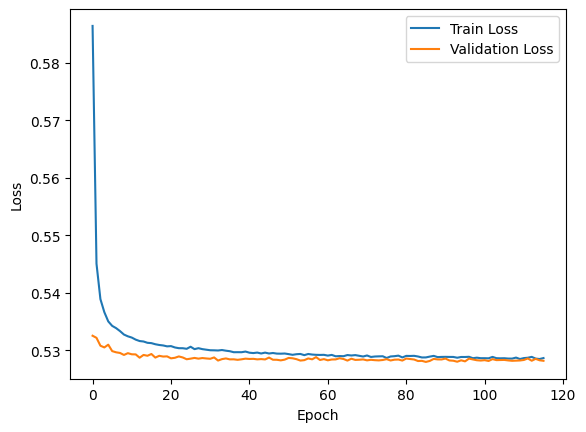


Enter lifter details:


Age (years):  20
Bodyweight (kg):  87
Sex (M/F):  M
First Squat Attempt (kg):  150
Wilks Score:  368
Planned 2nd Attempt (kg) [suggested: 157.5]:  160
Planned 3rd Attempt (kg) [suggested: 162.0]:  165



--- Predictions ---
2nd Attempt (160.0kg): 93.3% success probability
3rd Attempt (165.0kg): 84.7% success probability



Make another prediction? (y/n):  n


In [14]:
def main():
    model_path = 'squat_model.pth'
    scaler_path = 'scaler.pkl'
    data_path = '/kaggle/input/ipfopenpowerlift/ipfopenpowerlift.csv'

    # data Processing and Loading and Training
    if os.path.exists(model_path):
        print("Loading existing model and scalers...")
        df = load_data(data_path)
        df_clean = clean_data(df)

        # Need feature names for prediction function
        X_temp, _ = features_and_targets(df_clean)
        input_size = X_temp.shape[1]

        # Load model and scalers.
        model, scaler = load_model_and_scalers(input_size, model_path, scaler_path)
    else:
        print("Training new model...")
        df = load_data(data_path)
        df_clean = clean_data(df)
        X, y = features_and_targets(df_clean)
        input_size = X.shape[1]

        train_loader, test_loader, scaler, X_test_tensor, y_test, y_test_success = data_loaders(
            X, y, test_size=0.2, random_state=71
        )

        model, train_losses, val_losses = train_model(
            train_loader, test_loader, input_size, num_epochs=120
        )
     
        save_model_and_scalers(model, scaler)

        print("\n--- Evaluating newly trained model ---")
        evaluate_model(model, X_test_tensor, y_test_success, y_test)

        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    # Interactive loops for the prediction of attempts
    while True:
        predict_squat_success(model, scaler)
        if input("\nMake another prediction? (y/n): ").strip().lower() != 'y':
            break

if __name__ == "__main__":
    main()

I want the model to be able to be used again for predictions post training.

In [17]:

data_path = '/kaggle/input/ipfopenpowerlift/ipfopenpowerlift.csv'
df = load_data(data_path)
df_clean = clean_data(df)
X_temp, _ = features_and_targets(df_clean)  
input_size = X_temp.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FFSquatNet(input_size=input_size).to(device)
model.load_state_dict(torch.load('squat_model.pth', map_location=device))
model.eval()

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

predict_squat_success(model, scaler)

Original Shape of Dataset: (1365314, 42)
Shape of Cleaned Dataset: (400740, 42)
Shape of Features: (391287, 8)
Shape of Targets: (391287, 2)

Squat attempt success rates:
2nd attempt: 81.8%
3rd attempt: 62.0%

Enter lifter details:


Age (years):  20
Bodyweight (kg):  87
Sex (M/F):  M
First Squat Attempt (kg):  150
Wilks Score:  368
Planned 2nd Attempt (kg) [suggested: 157.5]:  155
Planned 3rd Attempt (kg) [suggested: 162.0]:  175



--- Predictions ---
2nd Attempt (155.0kg): 93.2% success probability
3rd Attempt (175.0kg): 84.5% success probability


Reflection:
This was my first machine learning project using PyTorch. I have some past experience and have taken some university modules on machine learning and R. Luckially, Python syntax is intuitive and I had no problem adjusting. Previous versions of the model were optimised for two variables, minimizing the probabillity of failure and maximizing the amount of weigth attempted. I was able to create such model, but it had inadequite accuracy. I decided to cut the complexity and create a model that can predict the probabillity of a successful squat attempt.